This notebook loads the pickled dictionary with the presidents' raw and aggregated popularity, concatenates the raw popularity of each one, and saves all these data in a unique CSV file for sharing

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [3]:
all_presidents = pd.read_excel("../data/raw_popularity_presidents.xlsx", index_col=0, parse_dates=True)
all_presidents

,president,sondage,samplesize,method,approve_pr,disapprove_pr
1978-09-28,vge,Kantar,1040,face to face,60,33
1978-10-17,vge,Ifop,949,phone,52,35
1978-10-28,vge,Kantar,964,face to face,59,34
1978-11-19,vge,Ifop,1069,phone,53,37
1978-11-24,vge,Kantar,928,face to face,62,33
...,...,...,...,...,...,...
2020-07-10,macron,Ifop,1018,internet,38,62
2020-07-16,macron,BVA,1000,internet,39,61
2020-07-16,macron,Ifop,974,internet,37,63
2020-07-22,macron,Harris,960,internet,50,50


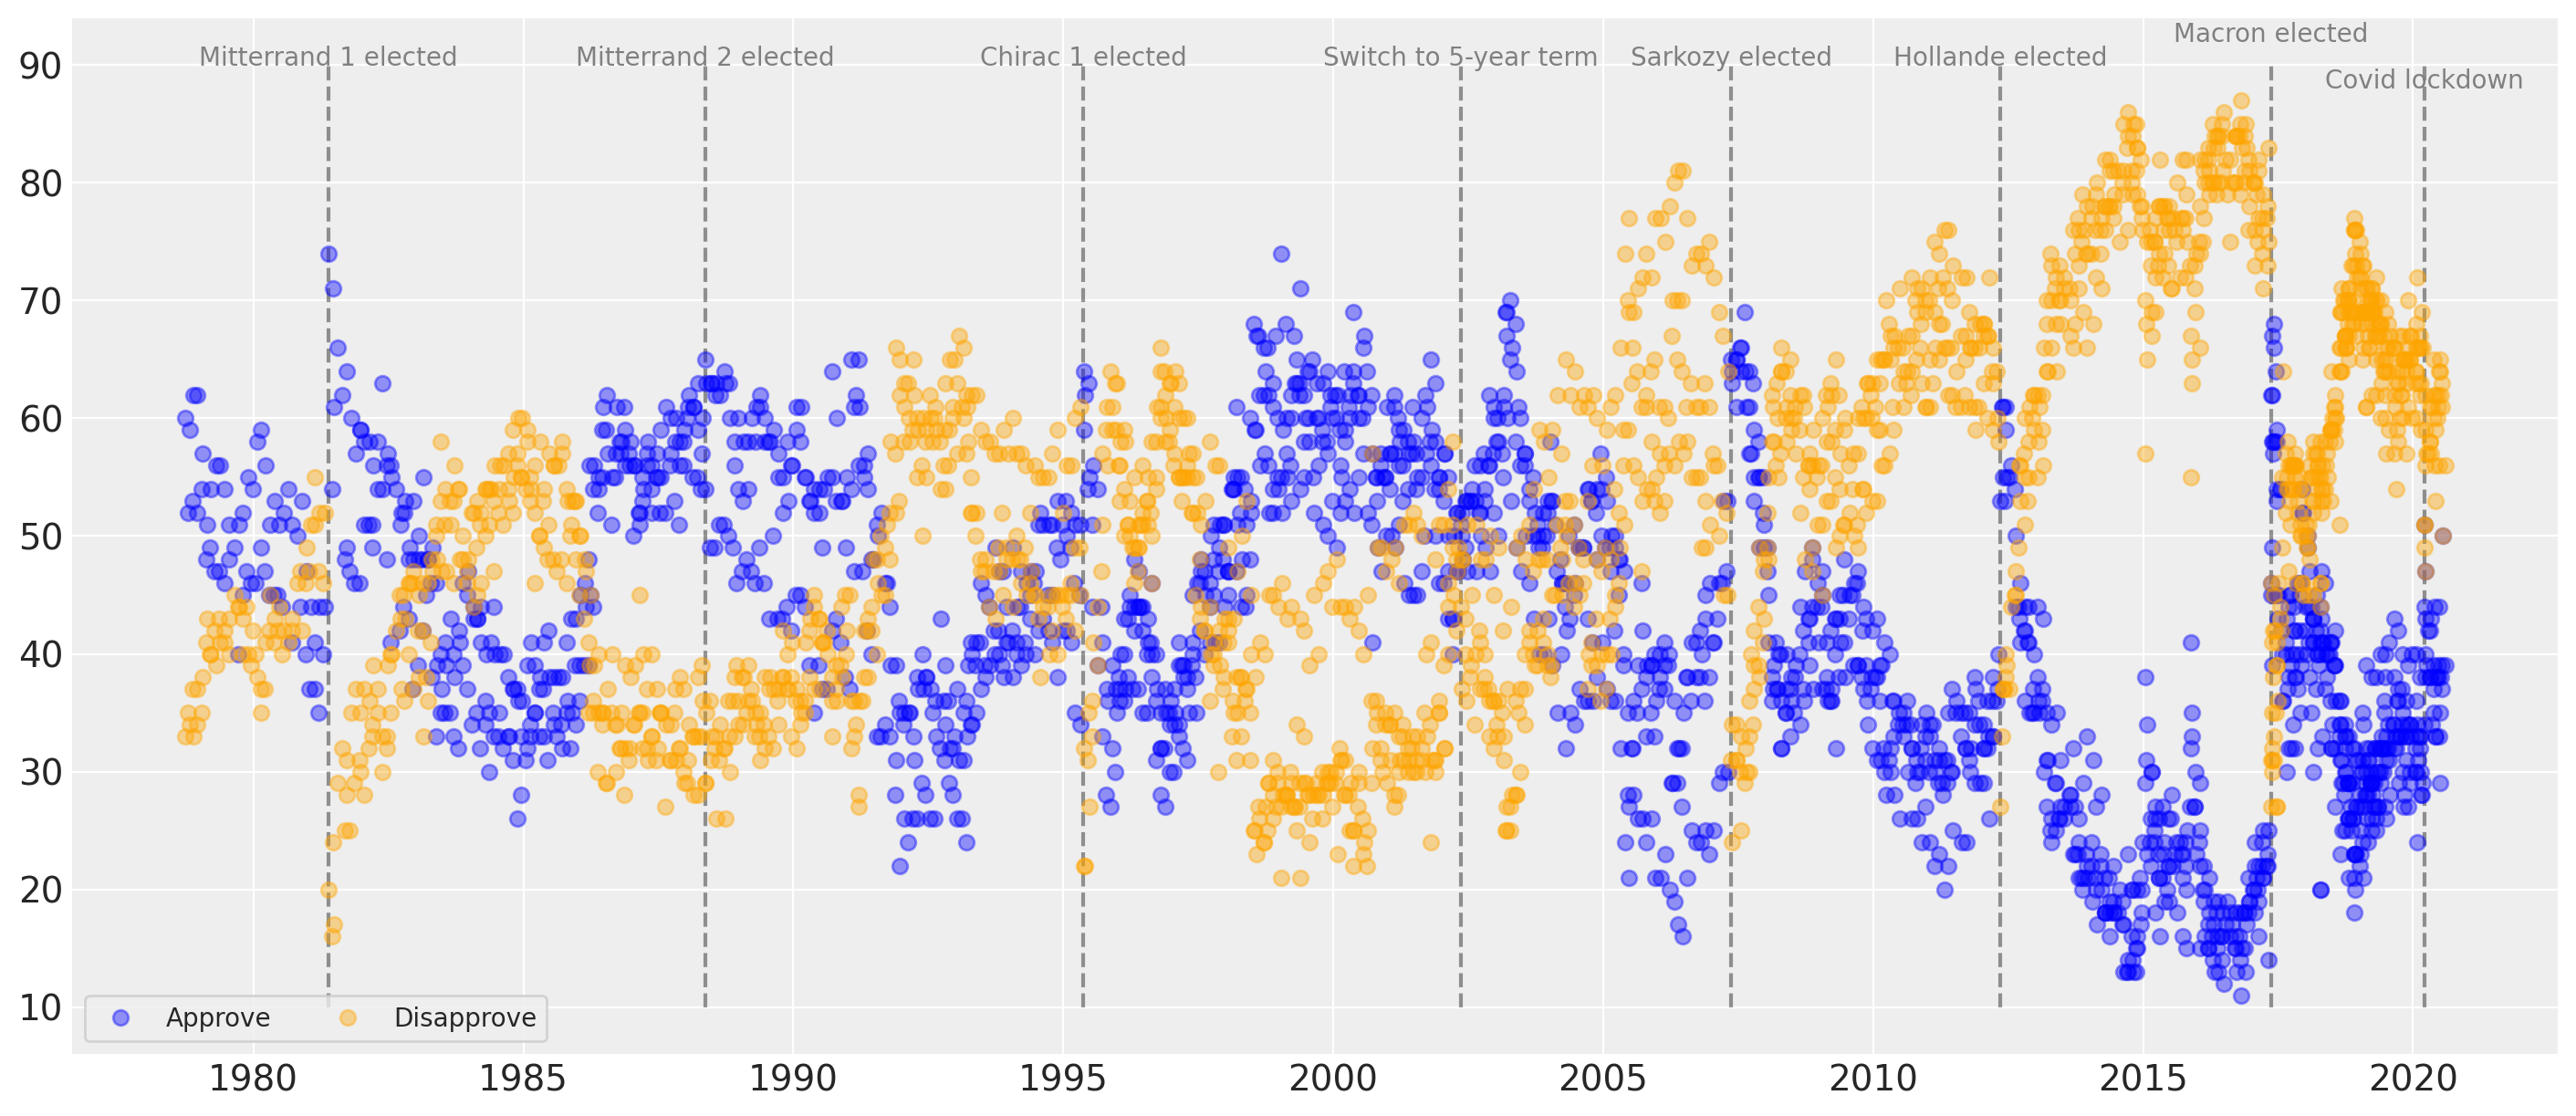

In [4]:
_, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(all_presidents.index, all_presidents.approve_pr, "ob", label="Approve", alpha=0.4)
ax.plot(all_presidents.index, all_presidents.disapprove_pr, "o", color="orange", label="Disapprove", alpha=0.4)

ax.vlines(pd.to_datetime("1981-05-25"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1981-05-25"), 90, "Mitterrand 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1988-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1988-05-16"), 90, "Mitterrand 2 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1995-05-18"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1995-05-18"), 90, "Chirac 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2002-05-14"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2002-05-14"), 90, "Switch to 5-year term", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2007-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2007-05-16"), 90, "Sarkozy elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2012-05-11"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2012-05-11"), 90, "Hollande elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2017-05-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2017-05-17"), 92, "Macron elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2020-03-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2020-03-17"), 88, "Covid lockdown", fontsize=10, color="grey", horizontalalignment="center")

plt.legend(fontsize=10, ncol=2, loc="lower left", frameon=True);

In [19]:
# restrict data to after the switch to 5-year term
d = all_presidents.loc[all_presidents.index >= pd.to_datetime("2002-05-05")]

# convert to proportions
d[["approve_pr", "disapprove_pr"]] = d[["approve_pr", "disapprove_pr"]].copy() / 100
d = d.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

# convert to nbr of successes
d["N_approve"], d["N_disapprove"] = d.samplesize * d["p_approve"], d.samplesize * d["p_disapprove"]
d[["N_approve", "N_disapprove"]] = d[["N_approve", "N_disapprove"]].round().astype(int)

# compute total trials
d["N_total"] = d.N_approve + d.N_disapprove
d

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,president,sondage,samplesize,method,p_approve,p_disapprove,N_approve,N_disapprove,N_total
2002-05-15,chirac2,Ifop,924,phone,0.51,0.44,471,407,878
2002-05-20,chirac2,Kantar,972,face to face,0.50,0.48,486,467,953
2002-05-23,chirac2,BVA,1054,phone,0.52,0.37,548,390,938
2002-05-26,chirac2,Ipsos,907,phone,0.48,0.48,435,435,870
2002-06-16,chirac2,Ifop,974,phone,0.49,0.43,477,419,896
...,...,...,...,...,...,...,...,...,...
2020-07-10,macron,Ifop,1018,internet,0.38,0.62,387,631,1018
2020-07-16,macron,BVA,1000,internet,0.39,0.61,390,610,1000
2020-07-16,macron,Ifop,974,internet,0.37,0.63,360,614,974
2020-07-22,macron,Harris,960,internet,0.50,0.50,480,480,960


In [22]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date. Useful for posterior predictions."""
    
    reference_time = timelist[0]
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    
    return np.asarray(t)

In [24]:
time = dates_to_idx(d.index)